In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor

import pickle
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import LinearSVR, SVR

from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error 

In [65]:
%matplotlib inline
np.random.seed(24680)
warnings.filterwarnings("ignore")

# Training a prediction model for the average rating of a book
---


In [66]:
books = pd.read_csv("books.csv",
                         error_bad_lines=False,
                         warn_bad_lines=False)

In [67]:
books.sample(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
3653,13180,The Private Parts of Women,Lesley Glaister,3.80,0747526036,9.780750e+12,eng,288,22,3,09/01/2002,Bloomsbury Publishing PLC
1291,4488,Bridget Jones's Guide to Life,Helen Fielding,3.49,0142000213,9.780140e+12,en-US,64,1104,34,04/01/2001,Penguin Books
6982,26426,Fullmetal Alchemist Vol. 12 (Fullmetal Alchem...,Hiromu Arakawa/Akira Watanabe,4.60,1421508397,9.781420e+12,eng,192,7480,119,3/20/2007,VIZ Media LLC
8407,32349,Mutant Message Down Under,Marlo Morgan,3.79,0060723513,9.780060e+12,eng,187,11224,1249,5/25/2004,Harper Perennial
204,477,Collapse of Complex Societies,Joseph A. Tainter,4.15,052138673X,9.780520e+12,eng,262,719,86,3/29/1990,Cambridge University Press


In [68]:
books.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9.780440e+12,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9.780440e+12,eng,870,2153167,29221,09/01/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9.780440e+12,eng,352,6333,244,11/01/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9.780440e+12,eng,435,2339585,36325,05/01/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9.780440e+12,eng,2690,41428,164,9/13/2004,Scholastic


In [69]:
books.shape

(11127, 12)

In [70]:
books.dtypes

bookID                  int64
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                float64
language_code          object
num_pages               int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
dtype: object

In [71]:
books.isna().any().any()

False

There are no NA values in the dataset.

Also bookID, isbn and isbn13 are just unique identifiers so I will drop them as they will not provide any additional information.

In [72]:
books = books.drop(["bookID", "isbn", "isbn13"], axis = 1)
books.sample(5)

,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
1639,The Double and The Gambler,Fyodor Dostoyevsky/Richard Pevear/Larissa Volo...,4.16,eng,344,2486,99,1/16/2007,Vintage Classics
4684,The Love of the Last Tycoon,F. Scott Fitzgerald,3.65,eng,169,7135,386,4/14/1995,Scribner
632,The Long Goodbye (Philip Marlowe #6),Raymond Chandler,4.22,eng,379,26389,1619,08/12/1988,Vintage Crime/Black Lizard
939,The Longest Journey,E.M. Forster/Gilbert Adair/Elizabeth Heine,3.48,eng,396,1665,125,7/27/2006,Penguin Classics
8162,Violin,Anne Rice,3.28,eng,289,15886,405,01/01/2002,Distribooks


The following heatmap displays the correlation between the features:


<Axes: >

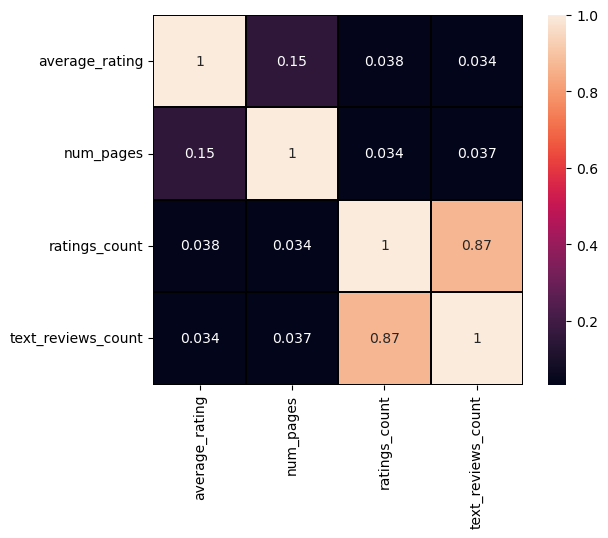

In [73]:
print("The following heatmap displays the correlation between the features:")

sns.heatmap(data=books.corr(),
            linewidths=0.25, square=True,
            linecolor="black", annot=True)

There is a high correlation between the ratings_count and the text_reviews_count (~ 86%). 
most likey when a person writes a review, he/she also rates the book

In [74]:
print("Let's examine the top 10 most rated books.")

most_rated = books.sort_values(by="ratings_count", ascending = False).head(10)

most_rated_titles = pd.DataFrame(most_rated.title).join(pd.DataFrame(most_rated.ratings_count))
most_rated_titles

Let's examine the top 10 most rated books.


,title,ratings_count
10340,Twilight (Twilight #1),4597666
1697,The Hobbit or There and Back Again,2530894
1462,The Catcher in the Rye,2457092
307,Angels & Demons (Robert Langdon #1),2418736
3,Harry Potter and the Prisoner of Azkaban (Harr...,2339585
4416,Harry Potter and the Chamber of Secrets (Harry...,2293963
1,Harry Potter and the Order of the Phoenix (Har...,2153167
23,The Fellowship of the Ring (The Lord of the Ri...,2128944
2114,Animal Farm,2111750
0,Harry Potter and the Half-Blood Prince (Harry ...,2095690


Text(0, 0.5, 'Titles')

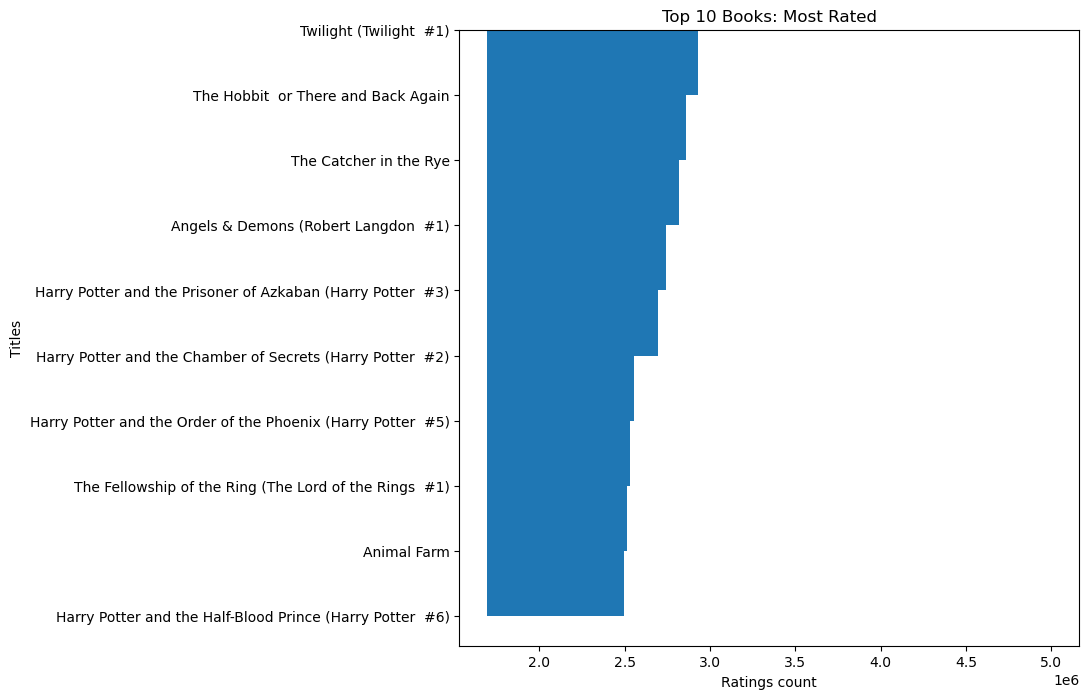

In [75]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.invert_yaxis()
plt.bar(most_rated_titles.ratings_count, most_rated_titles.title,
        align="center", width=800000)
plt.title("Top 10 Books: Most Rated")
plt.xlabel("Ratings count")
plt.ylabel("Titles")

In [76]:
def scatter_plot(x, y, title, x_label, y_label):
    plt.subplots(figsize=(8, 8))
    plt.scatter(x,
                y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

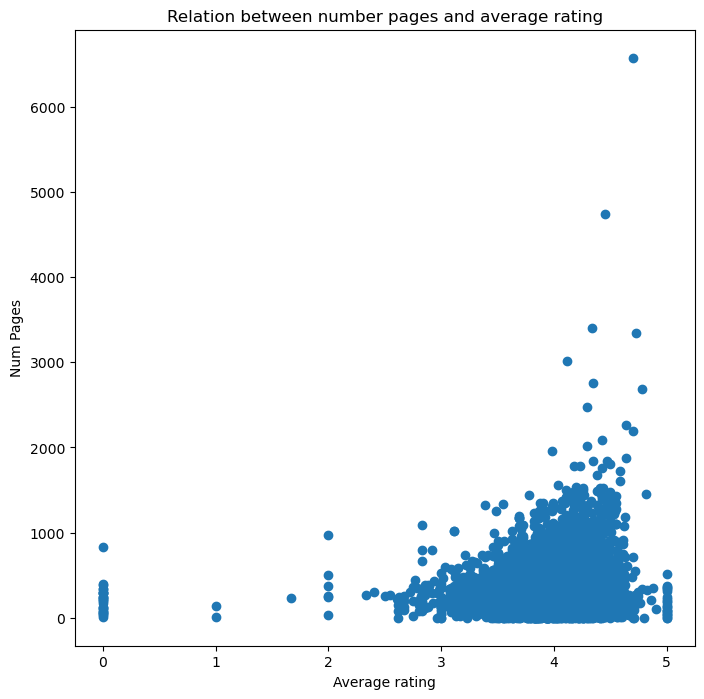

In [77]:
num_pages_and_average_rating_title = "Relation between number pages and average rating"
average_rating_label = "Average rating"
num_pages_label = "Num Pages"
scatter_plot(books.average_rating,
             books.num_pages,
            num_pages_and_average_rating_title, average_rating_label, num_pages_label)

There are a lot of outliers here. We can see that is no significant relation between average rating and the number of pages of a book.

The heatmap also proved this as it displayed a ration of 0.15

I Will drop the outliers (with num pages >= 2000).

In [78]:
print("Let`s focus on books ranging between 1-1500 pages.")
limited_by_num_pages_books = books[books.num_pages <= 1500]
limited_by_num_pages_books

Let`s focus on books ranging between 1-1500 pages.


,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,eng,870,2153167,29221,09/01/2004,Scholastic Inc.
2,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,eng,352,6333,244,11/01/2003,Scholastic
3,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,eng,435,2339585,36325,05/01/2004,Scholastic Inc.
5,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,en-US,152,19,1,4/26/2005,Nimble Books
...,...,...,...,...,...,...,...,...,...
11122,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,eng,512,156,20,12/21/2004,Da Capo Press
11123,You Bright and Risen Angels,William T. Vollmann,4.08,eng,635,783,56,12/01/1988,Penguin Books
11124,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,eng,415,820,95,08/01/1993,Penguin Books
11125,Poor People,William T. Vollmann,3.72,eng,434,769,139,2/27/2007,Ecco


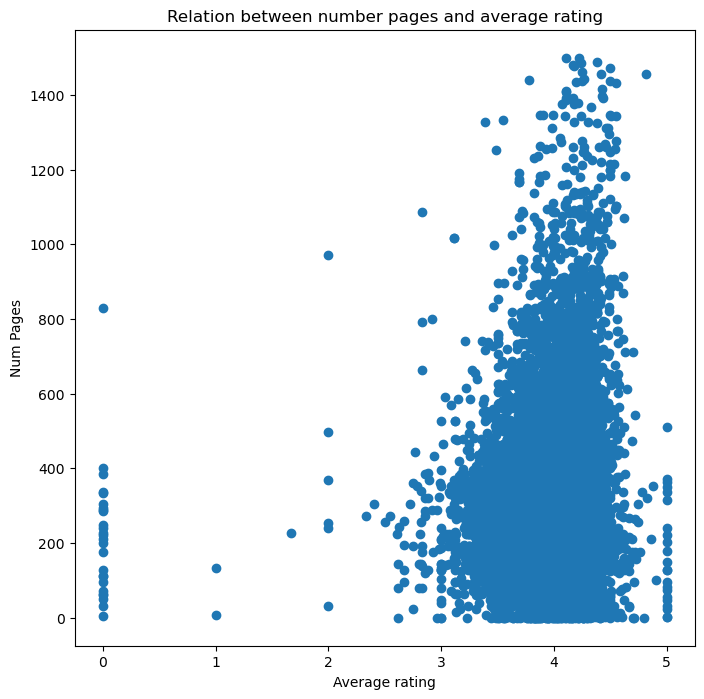

In [79]:
scatter_plot(limited_by_num_pages_books.average_rating,
             limited_by_num_pages_books.num_pages,
             num_pages_and_average_rating_title,
             average_rating_label,
             num_pages_label)

([], [])

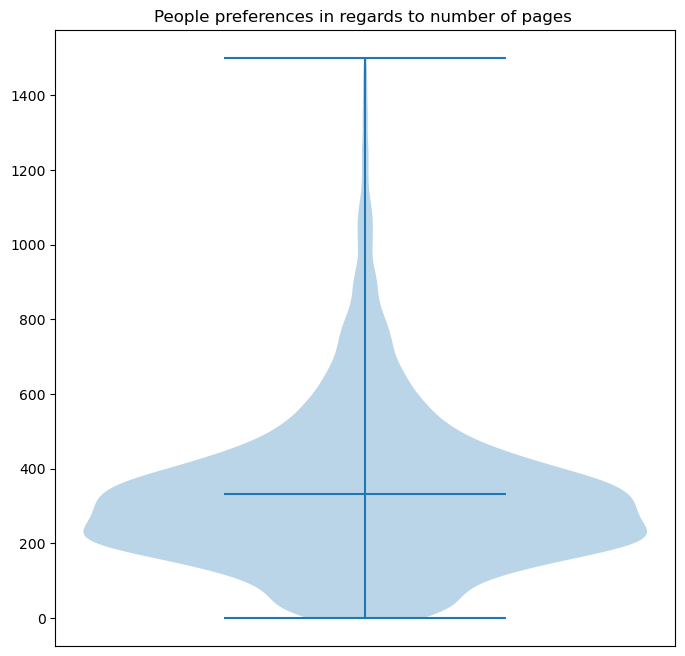

In [80]:
plt.subplots(figsize=(8, 8))
plt.title("People preferences in regards to number of pages ")
violionplot = plt.violinplot(limited_by_num_pages_books.num_pages, showmeans=True, points=1000, widths=1)
plt.xticks([], None)

We can conclude that people tend to prefer books with pages count between 200 and 400.

In [81]:
books[books["num_pages"] == 0]

,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
306,The 5 Love Languages / The 5 Love Languages Jo...,Gary Chapman,4.70,eng,0,22,4,01/01/2005,Moody Publishers
853,The Tragedy of Pudd'nhead Wilson,Mark Twain/Michael Prichard,3.79,eng,0,3,0,01/01/2003,Tantor Media
1061,Murder by Moonlight & Other Mysteries (New Adv...,NOT A BOOK,4.00,eng,0,7,2,10/03/2006,Simon Schuster Audio
1064,The Unfortunate Tobacconist & Other Mysteries ...,NOT A BOOK,3.50,eng,0,12,1,10/01/2003,Simon & Schuster Audio
1230,The Da Vinci Code (Robert Langdon #2),Dan Brown/Paul Michael,3.84,eng,0,91,16,3/28/2006,Random House Audio
...,...,...,...,...,...,...,...,...,...
10030,The Chessmen of Mars (Barsoom #5),Edgar Rice Burroughs/John Bolen,3.83,eng,0,5147,157,01/01/2005,Tantor Media
10192,Fine Lines (One-Eyed Mack #6),Jim Lehrer,3.23,eng,0,17,4,11/19/1995,Random House Value Publishing
10624,Stowaway and Milk Run: Two Unabridged Stories ...,Mary Higgins Clark/Jan Maxwell,3.49,eng,0,64,2,12/01/1999,Simon & Schuster Audio
10926,The Mask of the Enchantress,Victoria Holt,3.85,eng,0,21,1,10/12/1981,Ivy Books


There are 0 values in the pages_count column. Will replace them with the mean of the column.

Text(0.5, 1.0, 'Boxplot of number of pages')

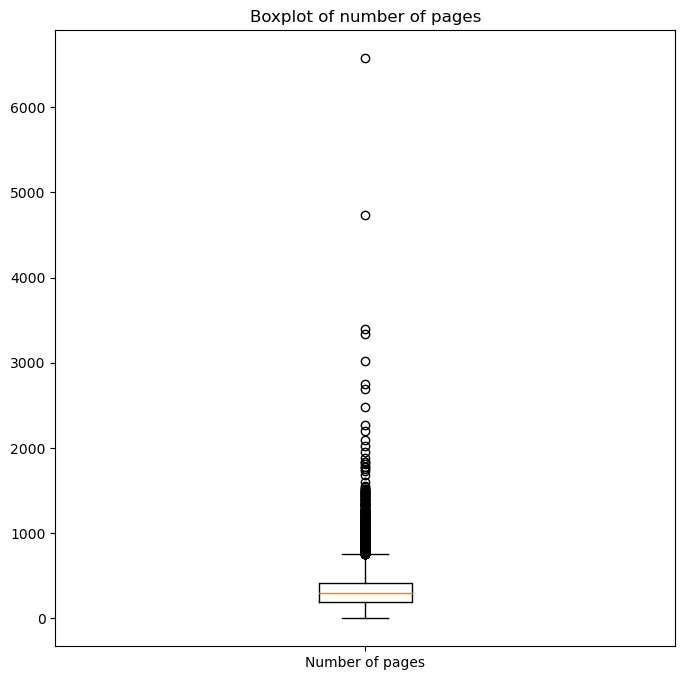

In [82]:
plt.subplots(figsize=(8,8))
plt.boxplot(books.num_pages)
plt.xticks([1], ["Number of pages"])
plt.title("Boxplot of number of pages")

In [83]:
print("Mean of number of pages", float(floor(books.num_pages.mean())))

Mean of number of pages 336.0


In [84]:
books.num_pages = books.num_pages.replace(0, np.nan)
books.num_pages.fillna(float(floor(books.num_pages.mean())), inplace=True)

print("Count of 0s in number of pages column:", len(books[books["num_pages"] == 0]))
print("Are there any NaNs in number of pages column:" , books.num_pages.isna().any().any())

Count of 0s in number of pages column: 0
Are there any NaNs in number of pages column: False


In [85]:
books

,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,eng,652.0,2095690,27591,9/16/2006,Scholastic Inc.
1,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,eng,870.0,2153167,29221,09/01/2004,Scholastic Inc.
2,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,eng,352.0,6333,244,11/01/2003,Scholastic
3,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,eng,435.0,2339585,36325,05/01/2004,Scholastic Inc.
4,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,eng,2690.0,41428,164,9/13/2004,Scholastic
...,...,...,...,...,...,...,...,...,...
11122,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,eng,512.0,156,20,12/21/2004,Da Capo Press
11123,You Bright and Risen Angels,William T. Vollmann,4.08,eng,635.0,783,56,12/01/1988,Penguin Books
11124,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,eng,415.0,820,95,08/01/1993,Penguin Books
11125,Poor People,William T. Vollmann,3.72,eng,434.0,769,139,2/27/2007,Ecco


Text(0.5, 1.0, 'Boxplot of count of ratings')

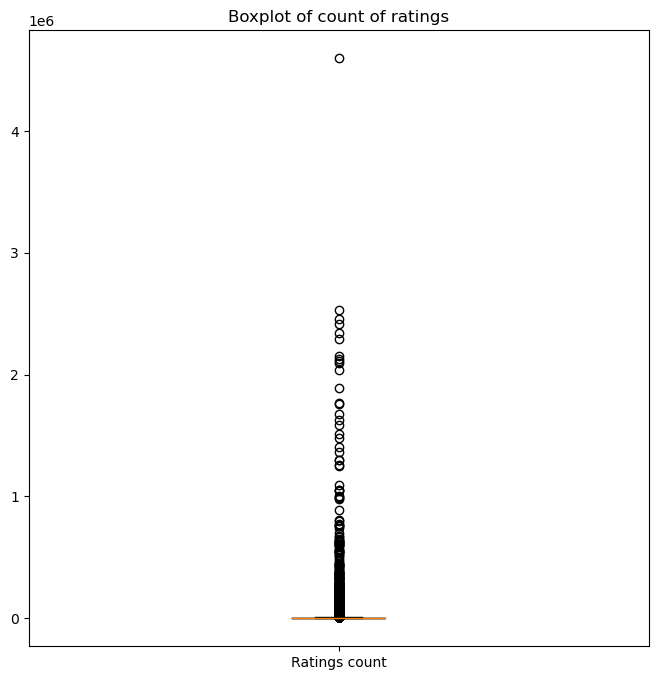

In [86]:
plt.subplots(figsize=(8,8))
plt.boxplot(books.ratings_count)
plt.xticks([1], ["Ratings count"])
plt.title("Boxplot of count of ratings")

There are a few  ourliers here. I will leave them as they are the most popular books (Twilight and The Hobbit or There and Back Again).

I`m going to encode all the string and categorical variables.

In [87]:
books = books.drop(["publication_date","publisher"], axis = 1)
books.sample(5)

,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count
9567,Crime Partners,Donald Goines,4.20,eng,159.0,474,21
9402,Certain Prey (Lucas Davenport #10),John Sandford,4.22,eng,384.0,15377,416
9064,Jimmy Stewart: Bomber Pilot,Starr Smith/Walter Cronkite,3.93,eng,320.0,441,57
946,The Rescue (Kidnapped #3),Gordon Korman,4.11,eng,140.0,1864,117
3402,Traveller,Richard Adams,3.92,eng,355.0,884,74


In [88]:
encoder = LabelEncoder()
books.title = encoder.fit_transform(books.title)
books.sample(5)
books.authors = encoder.fit_transform(books.authors)

In [89]:
books = pd.get_dummies(books)

In [90]:
books.sample(5)

,title,authors,average_rating,num_pages,ratings_count,text_reviews_count,language_code_ale,language_code_ara,language_code_en-CA,language_code_en-GB,...,language_code_nl,language_code_nor,language_code_por,language_code_rus,language_code_spa,language_code_srp,language_code_swe,language_code_tur,language_code_wel,language_code_zho
2676,1057,2322,3.84,338.0,28,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1980,6577,3142,3.82,326.0,5290,321,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3695,1360,1219,3.94,402.0,3896,65,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9727,6362,4895,3.23,224.0,29,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
329,7677,4884,3.98,418.0,200744,7656,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
books.shape

(11127, 33)

Text(0.5, 1.0, 'Boxplot of number of pages')

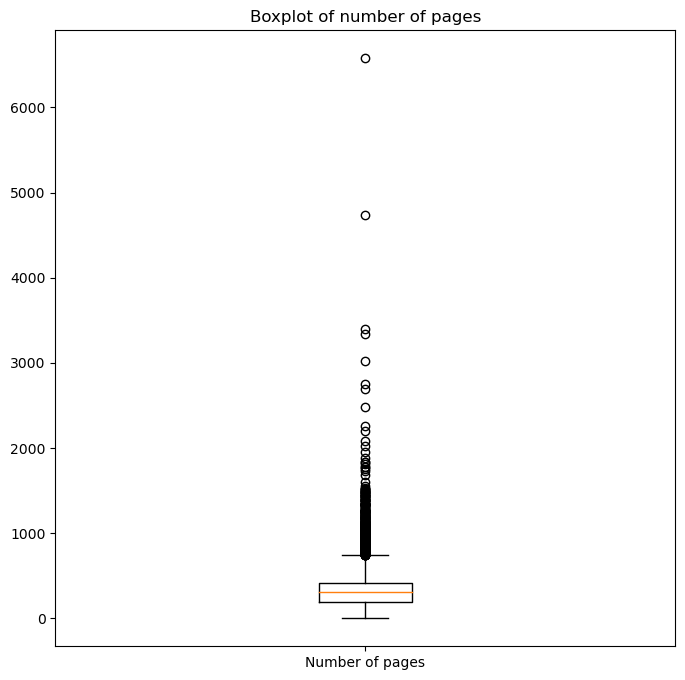

In [92]:
plt.subplots(figsize=(8,8))
plt.boxplot(books.num_pages)
plt.xticks([1], ["Number of pages"])
plt.title("Boxplot of number of pages")

Now we will focus on the target (i.e the average_rating). A histogram is a good way to visualize the sample.

Text(0.5, 1.0, 'Histogram of the average rating')

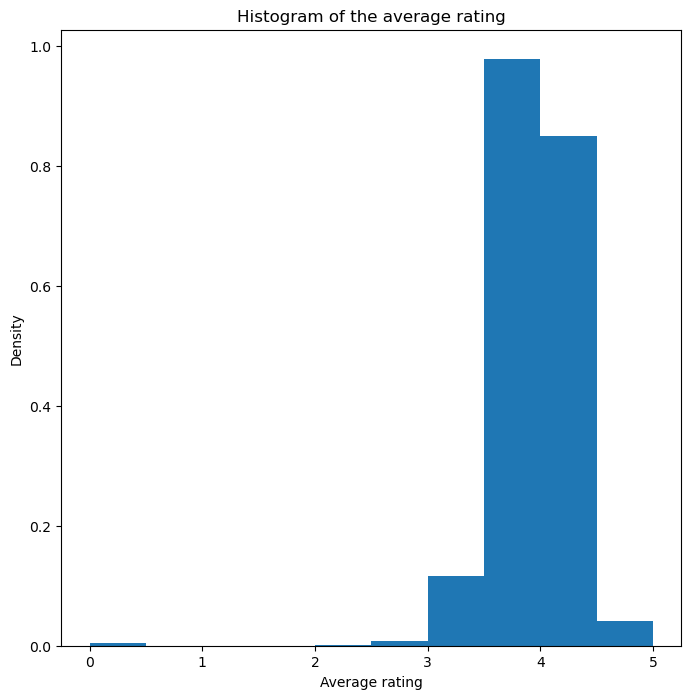

In [93]:
plt.subplots(figsize=(8,8))
plt.hist(books.average_rating,density=True)
plt.xlabel("Average rating")
plt.ylabel("Density")
plt.title("Histogram of the average rating")

From the histogram we see that most of ratings vary from 3 to 4.5. We can conclude that people tend to like the books they rate thus most of the ratings are very high.

### Chosing the best model for regression
I'm going to try whether we can use the non-modified data for predictions. If the scores are not good I will try to transform the data using a polynom and repeat the same steps and parameter tuning.

In [94]:
book=StandardScaler().fit_transform(books)
books_attributes =books.drop("average_rating", axis =1)
books_labels =books.average_rating

X_train, X_test, y_train, y_test = train_test_split (books_attributes, books_labels, test_size = 0.3)

In [95]:
k_fold = list(KFold(n_splits=5, shuffle=True).split(X_train, y_train))

In [96]:
def grid_search_best_model(model, params, k_fold, X_train, y_train):
    grid_search = GridSearchCV(model,
                           params,                             
                          cv=k_fold).fit(X_train,y_train)
    print("Best params", grid_search.best_params_)
    print("Best estimator", grid_search.best_estimator_)
    print("Best score:", grid_search.best_score_)
    
    return grid_search.best_estimator_

In [97]:
model_results = {}

def score_model(model,X_train, X_test, y_train, y_test,
               show_plot=True):   
    y_pred = model.predict(X_test)  
    print(f"Training score: {model.score(X_train,y_train)}")
    print(f"Test score: {r2_score(y_test, y_pred)}")
    print("MSE: ", mean_squared_error(y_test, y_pred))
    
    predictions_comparision = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).sample(25)
    if show_plot == True:
        predictions_comparision.plot(kind="bar", figsize=(12,8),title="Actual vs predicted values")
    print(predictions_comparision.sample(10))    
    
    
    return {
        "training_score": model.score(X_train,y_train),
        "test_score_r2" : r2_score(y_test, y_pred),
        "test_score_mse" : mean_squared_error(y_test, y_pred)
    }

def compare_results():
    for key in model_results:
        print("Regression: ", key)
        print("Trainign score", model_results[key]["training_score"])
        print("R2 Test score ", model_results[key]["test_score_r2"])
        print("MSE Test score ", model_results[key]["test_score_mse"])
        print()

Best params {'fit_intercept': True}
Best estimator LinearRegression()
Best score: 0.030976745043480913
Training score: 0.03816976771724245
Test score: 0.020057874889211624
MSE:  0.12440434674127596
      Actual  Predicted
189     3.99   3.895822
1653    4.19   3.962162
997     4.38   3.952445
2898    4.06   3.903472
2264    3.87   3.936814
1856    4.06   3.889324
1976    4.06   3.886433
534     3.71   3.920245
1920    4.22   3.902164
846     4.08   3.890546


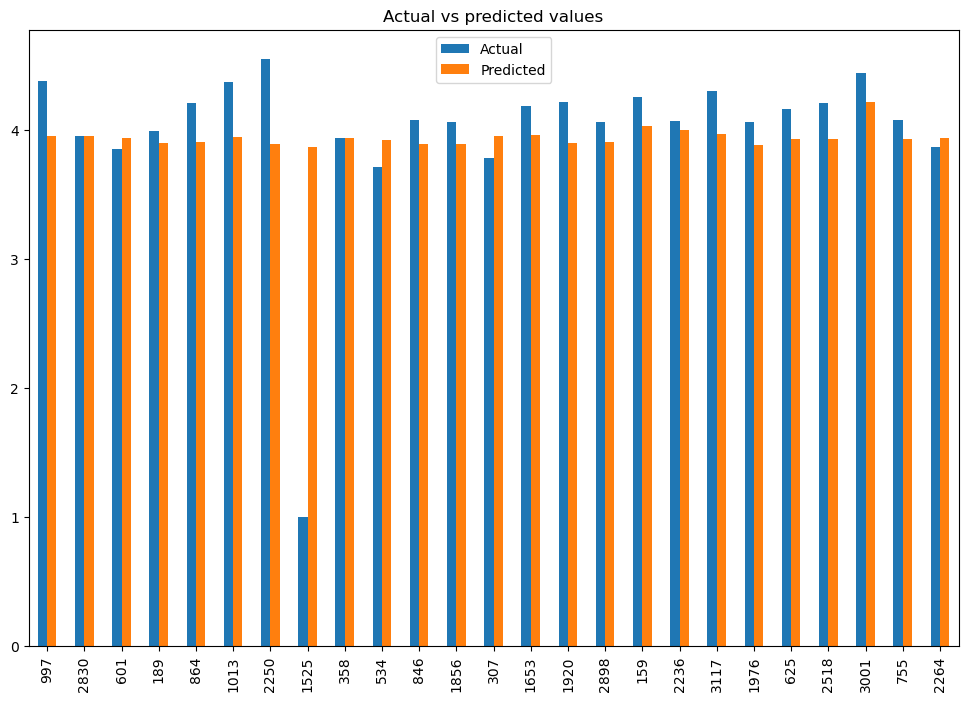

In [98]:
params={
    "fit_intercept":[True,False],
}

linear_regression = grid_search_best_model(LinearRegression(), params, k_fold, X_train, y_train)
model_results["linear_regression"] = score_model(linear_regression, X_train, X_test, y_train, y_test)

Best params {'leaf_size': 20, 'n_neighbors': 29}
Best estimator KNeighborsRegressor(leaf_size=20, n_neighbors=29)
Best score: -0.004714693544516502
Training score: 0.06847803663121599
Test score: 0.014421769704424658
MSE:  0.1251198542857641
      Actual  Predicted
1504    4.01   3.992069
1495    4.03   3.976552
337     3.86   3.925517
2619    4.15   3.947241
866     4.20   4.136207
616     4.31   3.980345
2029    3.85   3.900690
2122    3.35   3.643103
2550    3.87   3.977931
1431    4.05   3.792414


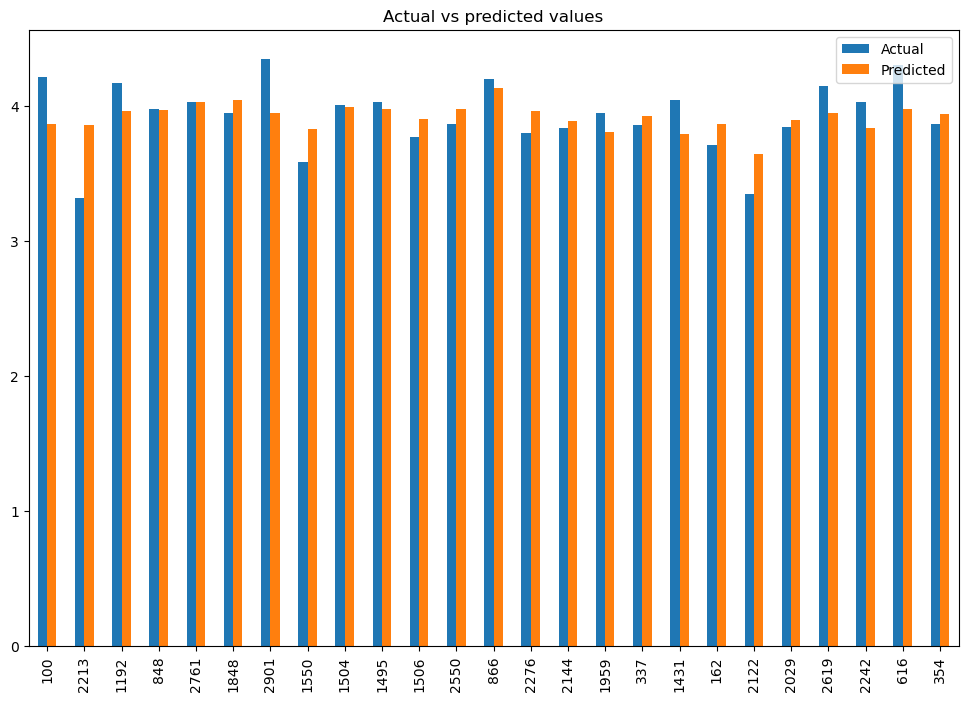

In [99]:
params={
    "n_neighbors": range(2, 30),
    "leaf_size":[20,30,50,70]
}

knn = grid_search_best_model(KNeighborsRegressor(), params, k_fold, X_train, y_train)
model_results["knn"] = score_model(knn, X_train, X_test, y_train, y_test)

Best params {'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 40}
Best estimator DecisionTreeRegressor(max_depth=6, max_leaf_nodes=20, min_samples_leaf=5,
                      min_samples_split=40)
Best score: 0.1323336787822555
Training score: 0.20674499347653164
Test score: 0.09931292579358775
MSE:  0.11434286190349456
      Actual  Predicted
260     4.08   3.933396
5       4.11   3.933396
249     3.59   3.877657
1486    3.95   3.933396
949     3.60   3.960270
997     4.38   3.933396
465     3.97   3.960270
908     4.01   3.933396
321     3.80   4.092174
2987    3.45   3.877657


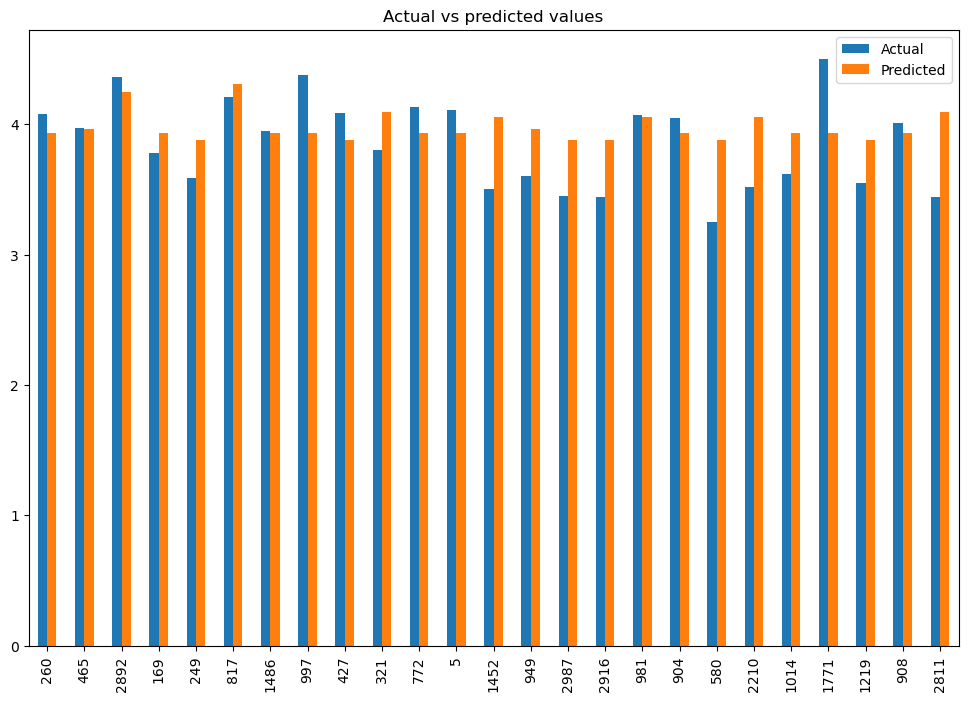

In [100]:
params = {    "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8, 15, 50],
              "min_samples_leaf": [5, 20, 30],
              "max_leaf_nodes": [5, 20],
              }
dtr = grid_search_best_model(DecisionTreeRegressor(), params, k_fold, X_train, y_train)
model_results["dtr"] = score_model(dtr, X_train, X_test, y_train, y_test)

Best params {'learning_rate': 0.3, 'n_estimators': 200}
Best estimator AdaBoostRegressor(learning_rate=0.3, n_estimators=200)
Best score: 0.09706480307800895
Training score: 0.17016707521763275
Test score: 0.10753205707611802
MSE:  0.11329943736669514
      Actual  Predicted
2308    4.09   3.895594
508     3.78   3.898435
265     3.29   3.903299
2504    3.87   3.898435
838     4.27   3.887030
1452    3.50   4.029465
2928    4.00   3.898435
1161    3.86   3.899956
2109    4.56   3.905385
1792    3.67   3.899956


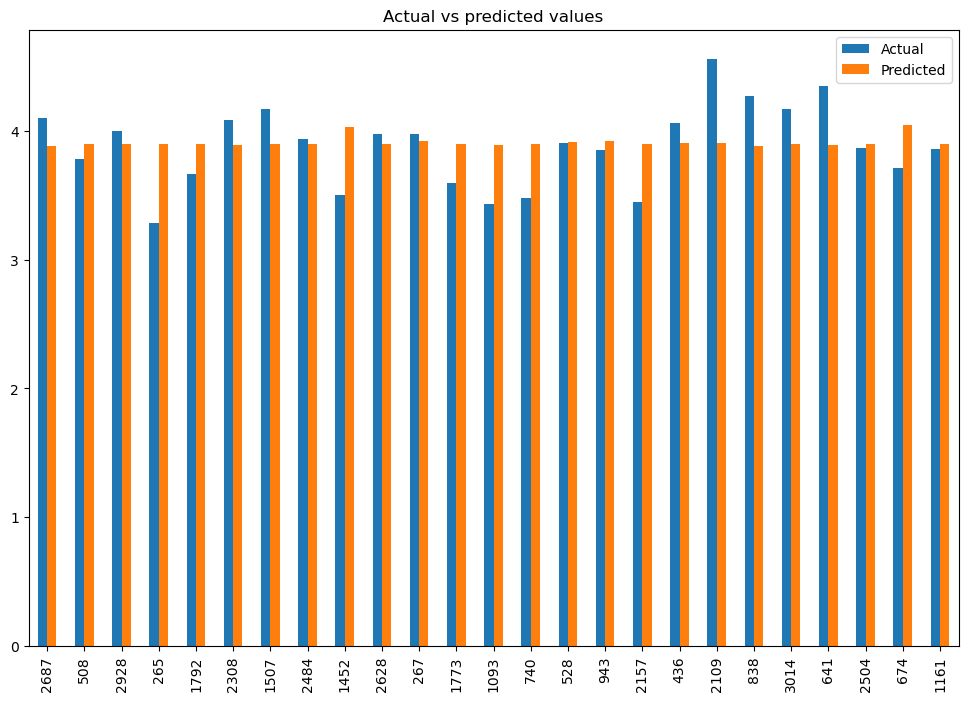

In [101]:
params = {"learning_rate":[0.3, 0.5,1],
          "n_estimators": [50, 100,200,400,700,1000]
              }
abr = grid_search_best_model(AdaBoostRegressor(), params, k_fold, X_train, y_train)
model_results["abr"] = score_model(abr, X_train, X_test, y_train, y_test)

The data is normalized using the standar scaler. Will try to use relatively small C.

Best params {'C': 10, 'fit_intercept': True}
Best estimator LinearSVR(C=10)
Best score: -1302.312028586264
Training score: -1252.568044697254
Test score: -694.2771966481072
MSE:  88.26593248385419
      Actual  Predicted
3189    3.13   4.624036
106     4.28   3.649159
1296    0.00   2.957506
2855    4.35   2.679548
98      3.82   2.705839
3061    4.59   1.427388
2749    3.89   4.928932
2931    4.04   2.470034
1551    4.09  -3.812959
2564    3.97 -15.650634


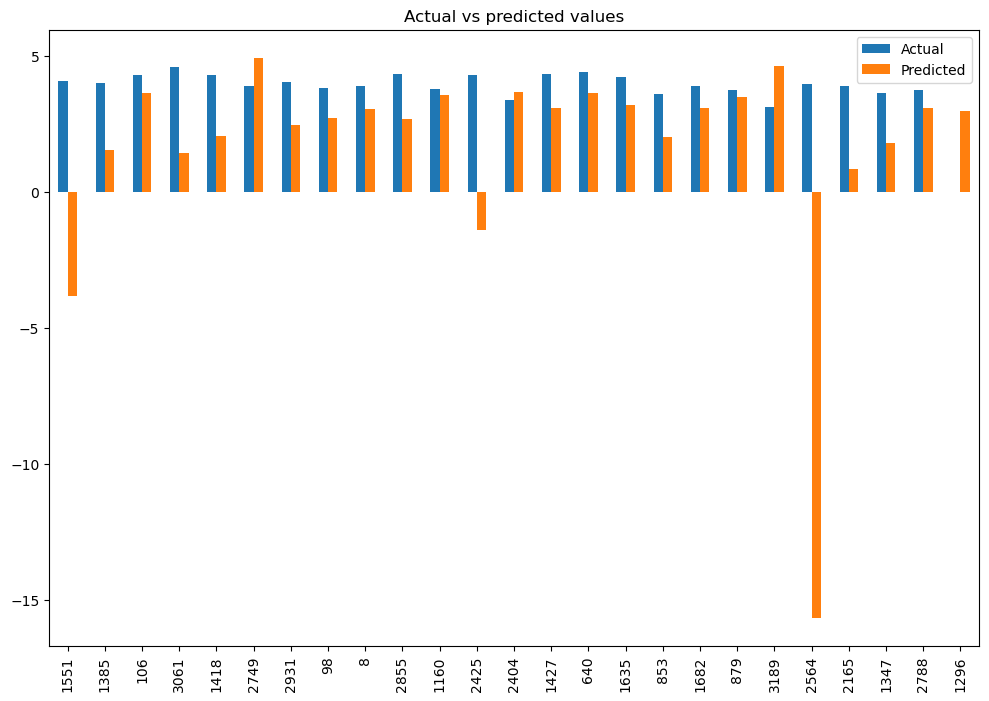

In [102]:
params = {
  "C": [0.1,1, 5, 10, 150,500,1000,5000],
    "fit_intercept":[True,False]
}
linear_svr = grid_search_best_model(LinearSVR(), params,k_fold, X_train, y_train)
model_results["linear_svr"] = score_model(linear_svr, X_train, X_test, y_train, y_test)

Best params {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 0.3, 'min_samples_leaf': 5, 'n_estimators': 200}
Best estimator GradientBoostingRegressor(max_features=0.3, min_samples_leaf=5,
                          n_estimators=200)
Best score: 0.14391928328864478
Training score: 0.31593153793448825
Test score: 0.1718896711414888
MSE:  0.10512919268543457
      Actual  Predicted
2105    4.04   3.898768
337     3.86   3.938617
2765    3.51   3.916011
160     4.29   3.966334
1351    3.71   4.009251
2871    4.19   4.018964
2776    3.65   3.876543
32      4.12   4.031895
1223    3.04   3.864511
2079    4.07   3.927253


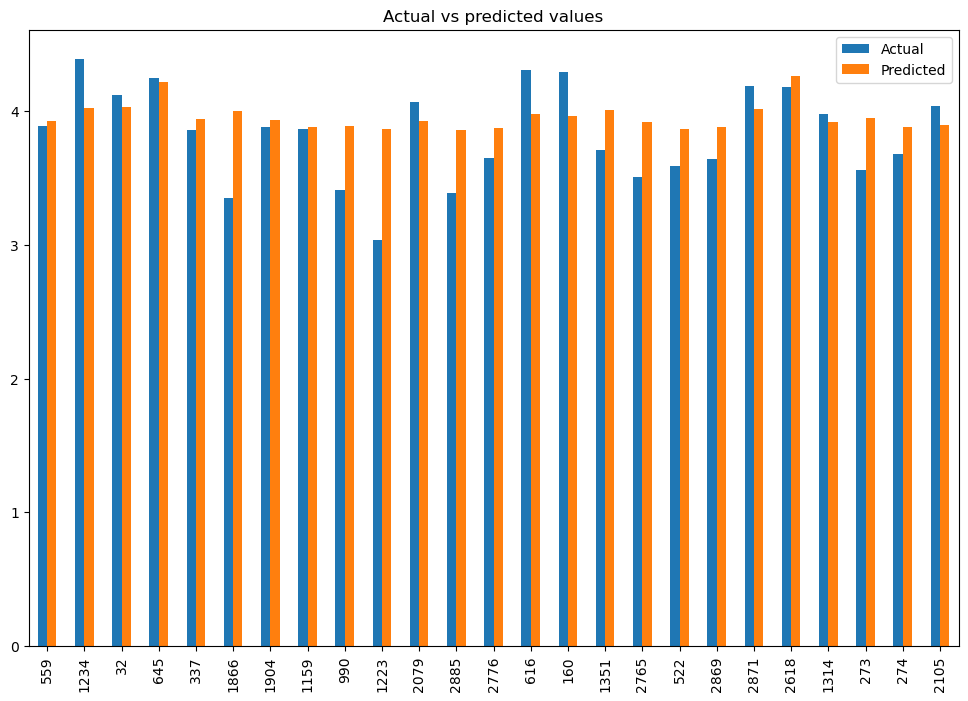

In [103]:
params={"n_estimators":[20, 50, 100,200], 
        "learning_rate": [0.01, 0.05, 0.1, 0.3],
         "max_depth":[3,5,10], 
        "min_samples_leaf": [3,5],
          "max_features": [0.3, 1]
       }        

gbr = grid_search_best_model(GradientBoostingRegressor(), params,k_fold, X_train, y_train)
model_results["gbr"] = score_model(gbr, X_train, X_test, y_train, y_test)

Best params {'C': 1, 'epsilon': 0.01, 'gamma': 0.001}
Best estimator SVR(C=1, epsilon=0.01, gamma=0.001)
Best score: 0.011490374766975297
Training score: 0.8260911759691573
Test score: 0.01798203093451778
MSE:  0.12466787660135961
      Actual  Predicted
638     3.81   3.942069
141     4.12   3.942069
308     4.00   3.942069
298     4.44   3.942069
778     3.71   3.942069
1016    3.97   3.942069
2345    3.75   3.942069
2118    4.03   3.942069
1282    4.54   3.942069
353     4.21   3.942069


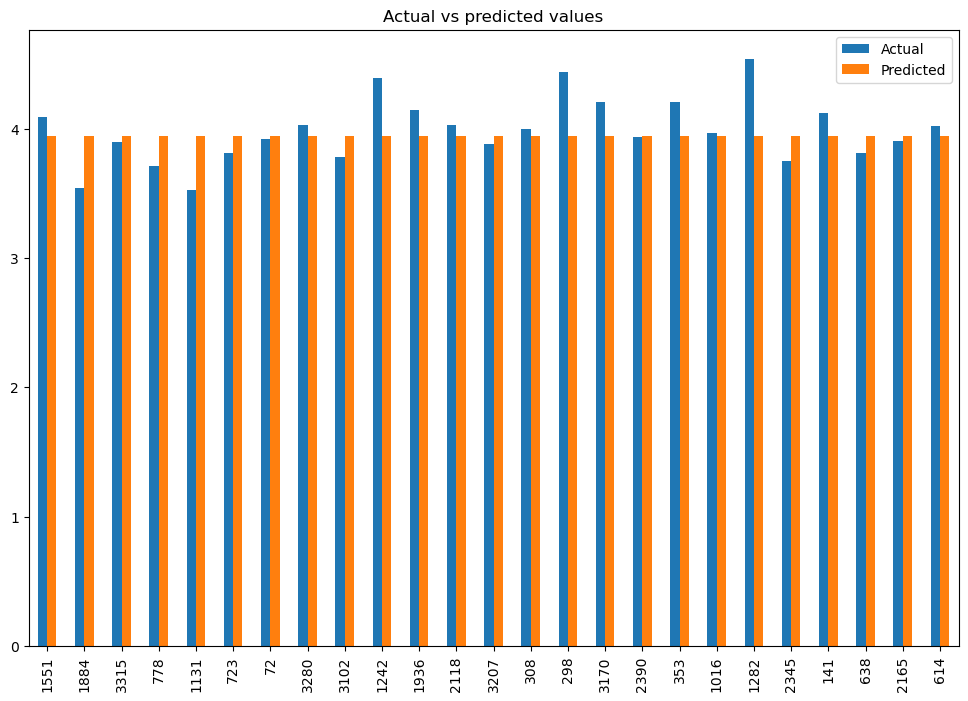

In [104]:
params = { 
    "C": [1, 5, 50, 100],
    "gamma": [0.001, 0.01, 0.1],
    "epsilon" : [0.01, 0.1]
}

gaussian_svr = grid_search_best_model(SVR(), params, k_fold,X_train, y_train)
model_results["gaussian_svr"] = score_model(gaussian_svr, X_train, X_test, y_train, y_test)

From what we can see the score of all algorithms are not very good. Plus some overfit. I will try
to transform the data with polynom of 2nd degree in order to improve the scores.

In [105]:
quad_transformer= PolynomialFeatures(degree=2, interaction_only=True)
books_attributes_quad_transformed = quad_transformer.fit_transform(books_attributes)
X_train_quad_transformed, X_test_quad_transformed, y_train_quad_transformed, y_test_quad_transformed = train_test_split (books_attributes_quad_transformed, books_labels, test_size = 0.3)
k_fold_quad_transformed = list(KFold(n_splits=5, shuffle=True).split(X_train_quad_transformed, y_train_quad_transformed))

Best params {'fit_intercept': False}
Best estimator LinearRegression(fit_intercept=False)
Best score: -75.19688873101063
Training score: 0.06821582692132622
Test score: -5.932325281087045
MSE:  0.8382184532806745
      Actual  Predicted
3048    3.51   3.895330
2794    3.97   3.859822
1167    4.28   4.066849
1464    3.84   3.950093
2528    4.03   3.922265
2742    3.86   3.931869
1976    4.02   3.933522
370     4.47   4.042615
2014    3.83   3.966457
1053    3.71   3.894397


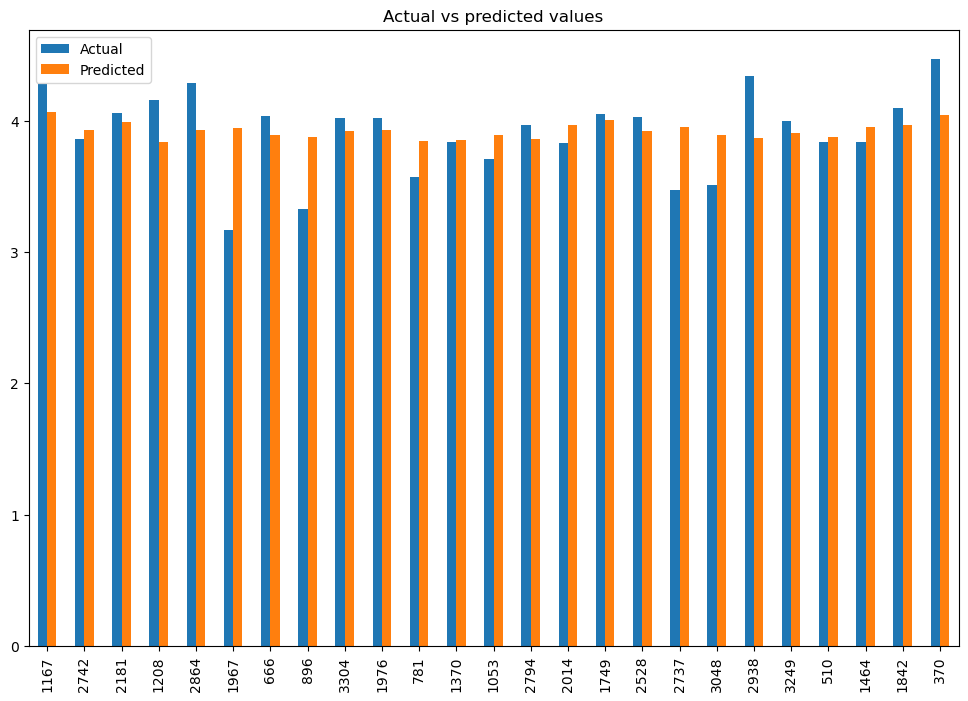

In [106]:
params={
    "fit_intercept":[True,False],
}

linear_regression_quad_transformed = grid_search_best_model(LinearRegression(), params, k_fold_quad_transformed,X_train_quad_transformed, y_train_quad_transformed)
model_results["linear_regression_quad_transformed"] = score_model(linear_regression_quad_transformed, X_train_quad_transformed, X_test_quad_transformed, y_train_quad_transformed, y_test_quad_transformed)

Best params {'learning_rate': 0.3, 'n_estimators': 400}
Best estimator AdaBoostRegressor(learning_rate=0.3, n_estimators=400)
Best score: 0.1331968301832032
Training score: 0.21450490505513786
Test score: -0.0008455779129039609
MSE:  0.12101671492244323
      Actual  Predicted
739     4.20   4.038351
2291    3.22   3.820796
25      4.19   3.882990
758     4.59   3.884926
2717    4.01   3.911739
1563    4.52   3.884926
2173    3.52   3.882990
1675    3.67   3.839884
2493    3.94   3.884216
3202    3.82   3.877795


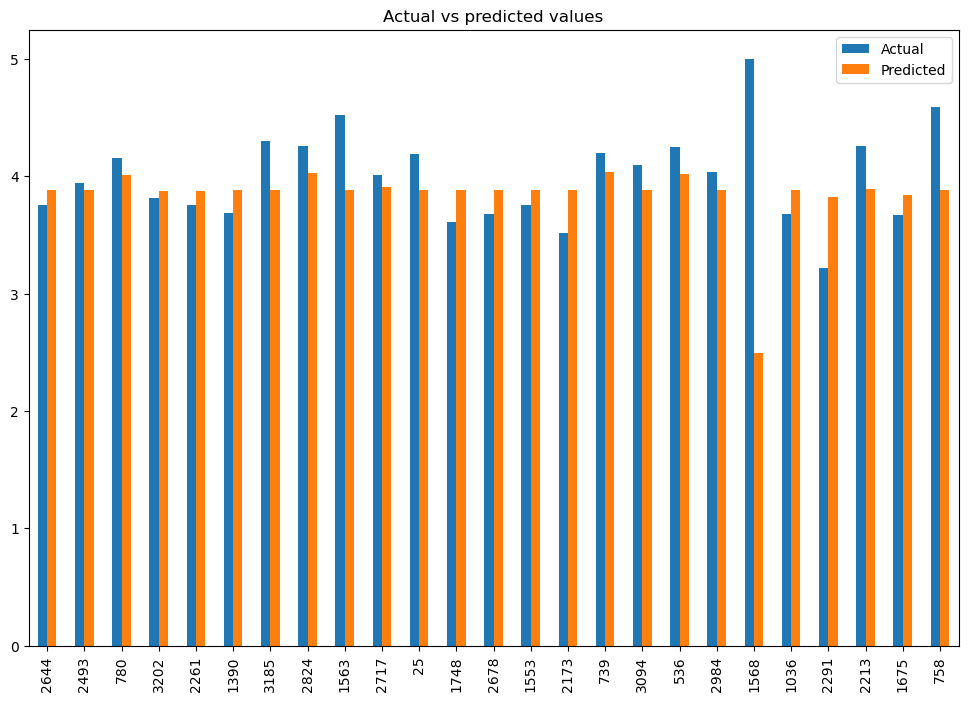

In [107]:
params = {"learning_rate":[0.3, 0.5,1],
          "n_estimators": [50, 100,200,400]}
              
abr_quad_transformed = grid_search_best_model(AdaBoostRegressor(), params,k_fold_quad_transformed,  X_train_quad_transformed, y_train_quad_transformed)
model_results["abr_quad_transformed"] = score_model(abr_quad_transformed, X_train_quad_transformed, X_test_quad_transformed, y_train_quad_transformed, y_test_quad_transformed)

Best params {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 0.3, 'min_samples_leaf': 3, 'n_estimators': 400}
Best estimator GradientBoostingRegressor(max_features=0.3, min_samples_leaf=3,
                          n_estimators=400)
Best score: 0.21064728883733785
Training score: 0.4986164766638682
Test score: 0.09602602550516137
MSE:  0.10930353611281056
      Actual  Predicted
1715    3.93   3.986896
2169    3.87   3.849329
2390    4.13   4.021795
3183    3.51   3.820414
842     3.85   3.893014
3176    3.30   3.837293
1598    3.95   3.943209
1557    3.89   3.911658
426     3.59   3.944638
2381    4.11   4.011922


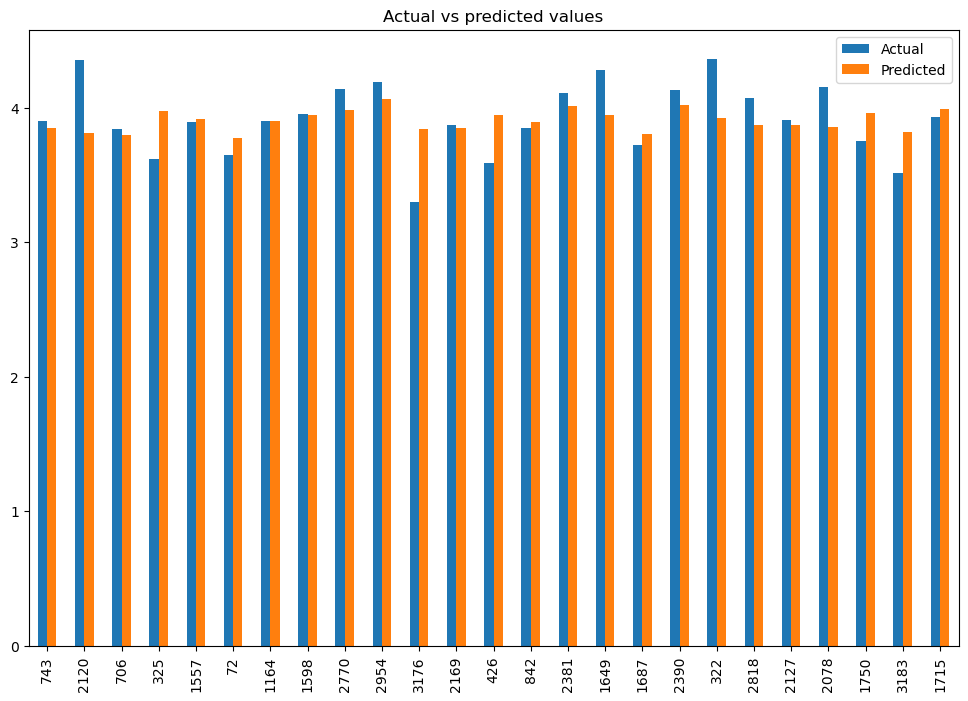

In [108]:
params={"n_estimators":[20, 50, 100,200,400], 
        "learning_rate": [0.01, 0.05, 0.1, 0.3],
         "max_depth":[3,5,10], 
        "min_samples_leaf": [3,5],
        "max_features": [0.3, 1]
       }        

gbr_quad_transformed = grid_search_best_model(GradientBoostingRegressor(), params,k_fold_quad_transformed,  X_train_quad_transformed, y_train_quad_transformed)
model_results["gbr_quad_transformed"] = score_model(gbr_quad_transformed,  X_train_quad_transformed,
                                                    X_test_quad_transformed, y_train_quad_transformed, y_test_quad_transformed)

### Comparing the results

In [110]:
### Comparing the results
compare_results()

Regression:  linear_regression
Trainign score 0.03816976771724245
R2 Test score  0.020057874889211624
MSE Test score  0.12440434674127596

Regression:  knn
Trainign score 0.06847803663121599
R2 Test score  0.014421769704424658
MSE Test score  0.1251198542857641

Regression:  dtr
Trainign score 0.20674499347653164
R2 Test score  0.09931292579358775
MSE Test score  0.11434286190349456

Regression:  abr
Trainign score 0.17016707521763275
R2 Test score  0.10753205707611802
MSE Test score  0.11329943736669514

Regression:  linear_svr
Trainign score -1252.568044697254
R2 Test score  -694.2771966481072
MSE Test score  88.26593248385419

Regression:  gbr
Trainign score 0.31593153793448825
R2 Test score  0.1718896711414888
MSE Test score  0.10512919268543457

Regression:  gaussian_svr
Trainign score 0.8260911759691573
R2 Test score  0.01798203093451778
MSE Test score  0.12466787660135961

Regression:  linear_regression_quad_transformed
Trainign score 0.06821582692132622
R2 Test score  -5.932325

From the observations we see that a GradientBoostingRegressor (GBR, the last one) with preprocessed data (using polynoms of 2nd degree) performed the best on the test data with score like ~21%. On the training data it did good - around 49%. However the overall scores are not very good but the actual vs. predicted data printed displays some satisfying results.

### Serializing the best model

In [111]:
model_dump_filename = "books_model.pkl"
pickle.dump(gbr_quad_transformed, open(model_dump_filename, "wb"))
print("Successfully dumped the model to", model_dump_filename)

Successfully dumped the model to books_model.pkl
